## Compare transports between control and basal/iceberg experiments

I am using some of Adele's scripts to calculate the transport in sigma 0 coordinates over the 1000m isobath. The scripts are located at `/home/156/cy8964/x77/Analysis/cross_slope_transports`. These are run each month and the output is in `/g/data/x77/cy8964/Post_Process/access-om2/##EXPT##` in monthly files.



In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client
import cmocean as cm


In [2]:
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36567/status,
Dashboard: /proxy/36567/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44799,Workers: 4
Dashboard: /proxy/36567/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:34247,Total threads: 2
Dashboard: /proxy/34861/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:33017,


### Make database

In [3]:
# session_name = '/home/156/wf4500/databases/access/DSW.db'
# session_name = '/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db'
# master_session = cc.database.create_session(session_name)
# control = '01deg_jra55v13_ryf9091_DSW'

In [4]:
# database for control simulation:
session_name = '/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db'
# master_session = cc.database.create_session(session_name)
#session_name = '/home/156/wf4500/databases/access/DSW.db'
master_session = cc.database.create_session(session_name)
control = '01deg_jra55v13_ryf9091_DSW'#_21mbath' #01deg_jra55v13_ryf9091_DSW'
#database for basal melt experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)
#experiments
basal_gade_woa = 'accessom2-GPC023'
basal_gade_woa_newname = '01deg_jra55v13_ryf9091_DSW_BasalGade_NoIcb'

icb_gade_woa = 'accessom2-GPC026'
icb_gade_woa_newname = '01deg_jra55v13_ryf9091_DSW_BasalGade_YesIcb'

basal_nogade_woa = '01deg_jra55v13_ryf9091_DSW_BasalNoGade_NoIcb'

### First plot contour

In [5]:
### Load Ade?le's isobath contour
isobath_depth = 1000
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']

In [6]:
lat_range = slice(-90,-59)

Text(0.5, 1.0, '1000m isobath contour')

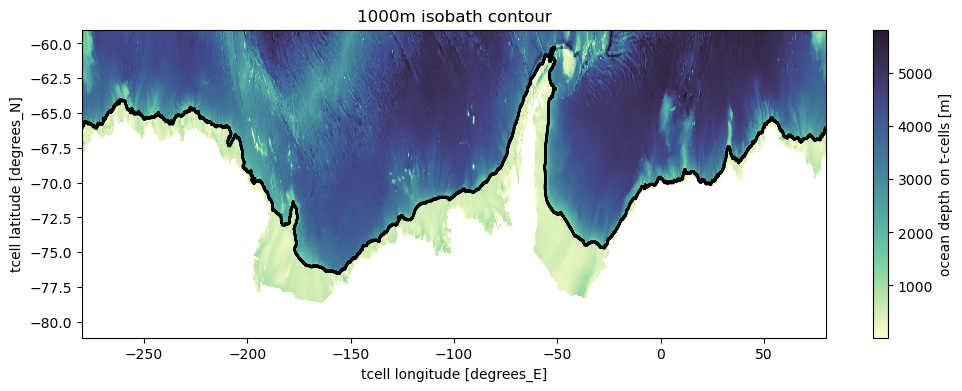

In [7]:
ht = cc.querying.getvar(control, 'ht',master_session, n=1, ncfile = 'ocean_grid.nc')
ht = ht.sel(yt_ocean=lat_range)
yt_ocean = cc.querying.getvar(control, 'yt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
xt_ocean = cc.querying.getvar(control, 'xt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)


fig, axes = plt.subplots(figsize = (12,4))
ht.plot(ax = axes, cmap = cm.cm.deep)
axes.contour(xt_ocean.values, yt_ocean.values,np.abs(mask_x_transport)+np.abs(mask_y_transport),colors = 'k')
axes.set_title('1000m isobath contour')
#plt.savefig('contour.png', dpi = 300)

### Make nicer y axis than `contour_index` by loading in lon/lat/distance of contour

according to cosima recipes https://nbviewer.org/github/claireyung/cosima-recipes/blob/master/DocumentedExamples/Cross-contour_transport.ipynb

In [8]:
expt = control
session = master_session

In [9]:
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(expt,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)
xu_ocean = cc.querying.getvar(expt,'xu_ocean',session,n=1)

# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for vhrho, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for uhrho, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.

mask_x_transport = xr.DataArray(mask_x_transport, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])

# ### Stack contour data into 1D

# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1,len(contour_ordering)+1)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean
# don't need the multi-index anymore, replace with contour count
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array



In [10]:
# ## save distance - this takes time so instead load result in next cell

# dxu = cc.querying.getvar(expt,'dxu',session,ncfile = 'ocean_grid.nc',n=1)
# dxu = dxu.sel(yu_ocean = lat_range)
# dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
# dyt = dyt.sel(yt_ocean = lat_range)
# num_points = len(lat_along_contour)
# lat_t = cc.querying.getvar(expt,'geolat_t',session,ncfile = 'ocean_grid.nc',n=1)
# lat_t = lat_t.sel(yt_ocean = lat_range)
# lon_t = cc.querying.getvar(expt,'geolon_t',session,ncfile = 'ocean_grid.nc',n=1)
# lon_t = lon_t.sel(yt_ocean = lat_range)

# # if there is a bend in the contour, add the distance using length of diagonal, not sum of
# # 2 edges, to be more representative.    
# distance_along_contour = np.zeros((num_points))
# x_indices = np.sort(mask_x_transport_numbered.values[mask_x_transport_numbered.values>0])
# y_indices = np.sort(mask_y_transport_numbered.values[mask_y_transport_numbered.values>0])
# skip = False
# for count in range(1,num_points):
#     if skip == True:
#         skip = False
#         continue
#     if count in y_indices:
#         if count + 1 in y_indices:
#             # note dxu and dyt do no vary in x:
#             jj = np.where(mask_y_transport_numbered==count)[0]
#             distance_along_contour[count-1] = (dxu[jj,990])[0]
#         else:
#             jj0 = np.where(mask_y_transport_numbered==count)[0]
#             jj1 = np.where(mask_x_transport_numbered==count+1)[0]
#             diagonal_distance = 0.5*np.sqrt((dxu[jj0,990])[0]**2+\
#                 (dyt[jj1,990])[0]**2)
#             distance_along_contour[count-1] = diagonal_distance
#             distance_along_contour[count] = diagonal_distance
#             # skip to next count:
#             skip = True
#     # count in x_indices:
#     else:
#         if count + 1 in x_indices:
#             jj = np.where(mask_x_transport_numbered==count)[0]
#             distance_along_contour[count-1] = (dyt[jj,990])[0]
#         else:
#             jj0 = np.where(mask_x_transport_numbered==count)[0]
#             jj1 = np.where(mask_y_transport_numbered==count+1)[0]
#             diagonal_distance = 0.5*np.sqrt((dyt[jj0,990])[0]**2+\
#                 (dxu[jj1,990])[0]**2)
#             distance_along_contour[count-1] = diagonal_distance
#             distance_along_contour[count] = diagonal_distance
#             # skip to next count:
#             skip = True
# # fix last value:
# if distance_along_contour[-1] == 0:
#     count = count + 1
#     if count in y_indices:
#         jj = np.where(mask_y_transport_numbered==count)[0]
#         distance_along_contour[-1] = (dxu[jj,990])[0]
#     else:
#         jj = np.where(mask_x_transport_numbered==count)[0]
#         distance_along_contour[-1] = (dyt[jj,990])[0]

# # units are 10^3 km:
# distance_along_contour = np.cumsum(distance_along_contour)/1e3/1e3 
# #save_dir = '/g/data/x77/cy8964/Post_Process/access-om2/'
# #ds_latlondist = xr.Dataset({'distance_along_contour': distance_along_contour})
# #ds_latlondist.to_netcdf(save_dir+'1000m_isobath_contour_distance.nc')

In [11]:
distance_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/access-om2/1000m_isobath_contour_distance.nc').distance_along_contour

In [12]:
#determine where to put lon tick marks
distance_indices = np.zeros(8)
for i in np.arange(100,len(lon_along_contour.values)):
    if (distance_indices[1]==0):
        if (lon_along_contour.values[i]>-240):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.values[i]>-180):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.values[i]>-120):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if lon_along_contour.values[i]>-60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.values[i]>0):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.values[i]>60):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
distance_indices[7] = len(lon_along_contour.contour_index.values)-1


### Transport cumulative sums for different density classes


In [13]:
AdelieW = -280
AdelieE = -200
RossW = -200
RossE = -150
WAW = -150
WAE = -65
WeddellW = -65
WeddellE = 0
PrydzW = 0
PrydzE = 80

In [14]:
distance_indices2 = np.zeros(8)
for i in np.arange(100,len(lon_along_contour.values)):
    if (distance_indices2[1]==0):
        if (lon_along_contour.values[i]>-200):
            distance_indices2[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices2[2]==0):
        if (lon_along_contour.values[i]>-150):
            distance_indices2[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices2[3]==0):
        if (lon_along_contour.values[i]>-65):
            distance_indices2[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices2[4]==0):
        if lon_along_contour.values[i]>0:
            distance_indices2[4] = lon_along_contour.contour_index.values[i]
distance_indices2[7] = len(lon_along_contour.contour_index.values)-1
distance_indices2

array([   0., 1270., 2149., 3338., 4798.,    0.,    0., 6001.])

In [15]:
inds= [1270, 2149, 3338, 4798]
distance_along_contour[inds]

<xarray.DataArray 'distance_along_contour' (distance_along_contour: 4)>
array([ 4.861785,  7.561025, 11.459365, 16.702661])
Coordinates:
  * distance_along_contour  (distance_along_contour) float64 4.862 ... 16.7

# Plot different sectors

In [16]:
AdelieW = -280
AdelieE = -200
RossW = -200
RossE = -150
WAW = -150
WAE = -65
WeddellW = -65
WeddellE = 0
PrydzW = 0
PrydzE = 80


### need to find corresponding contour indices

In [17]:
basin_indices = np.zeros(6)
for i in np.arange(100,len(lon_along_contour.values)):
    if (basin_indices[1]==0):
        if (lon_along_contour.values[i]>AdelieE):
            basin_indices[1] = lon_along_contour.contour_index.values[i]
    if (basin_indices[2]==0):
        if (lon_along_contour.values[i]>RossE):
            basin_indices[2] = lon_along_contour.contour_index.values[i]
    if (basin_indices[3]==0):
        if (lon_along_contour.values[i]>WAE):
            basin_indices[3] = lon_along_contour.contour_index.values[i]
    if (basin_indices[4]==0):
        if lon_along_contour.values[i]>WeddellE:
            basin_indices[4] = lon_along_contour.contour_index.values[i]
    if (basin_indices[5]==0):
        if (lon_along_contour.values[i]>PrydzE):
            basin_indices[5] = lon_along_contour.contour_index.values[i]
basin_indices

array([   0., 1270., 2149., 3338., 4798.,    0.])

In [18]:
lon_along_contour.contour_index.values[-1]

6002

In [19]:
Adelie = slice(basin_indices[0],basin_indices[1])
Ross = slice(basin_indices[1],basin_indices[2])
WA = slice(basin_indices[2],basin_indices[3])
Weddell = slice(basin_indices[3], basin_indices[4])
Prydz = slice(basin_indices[4],6002)

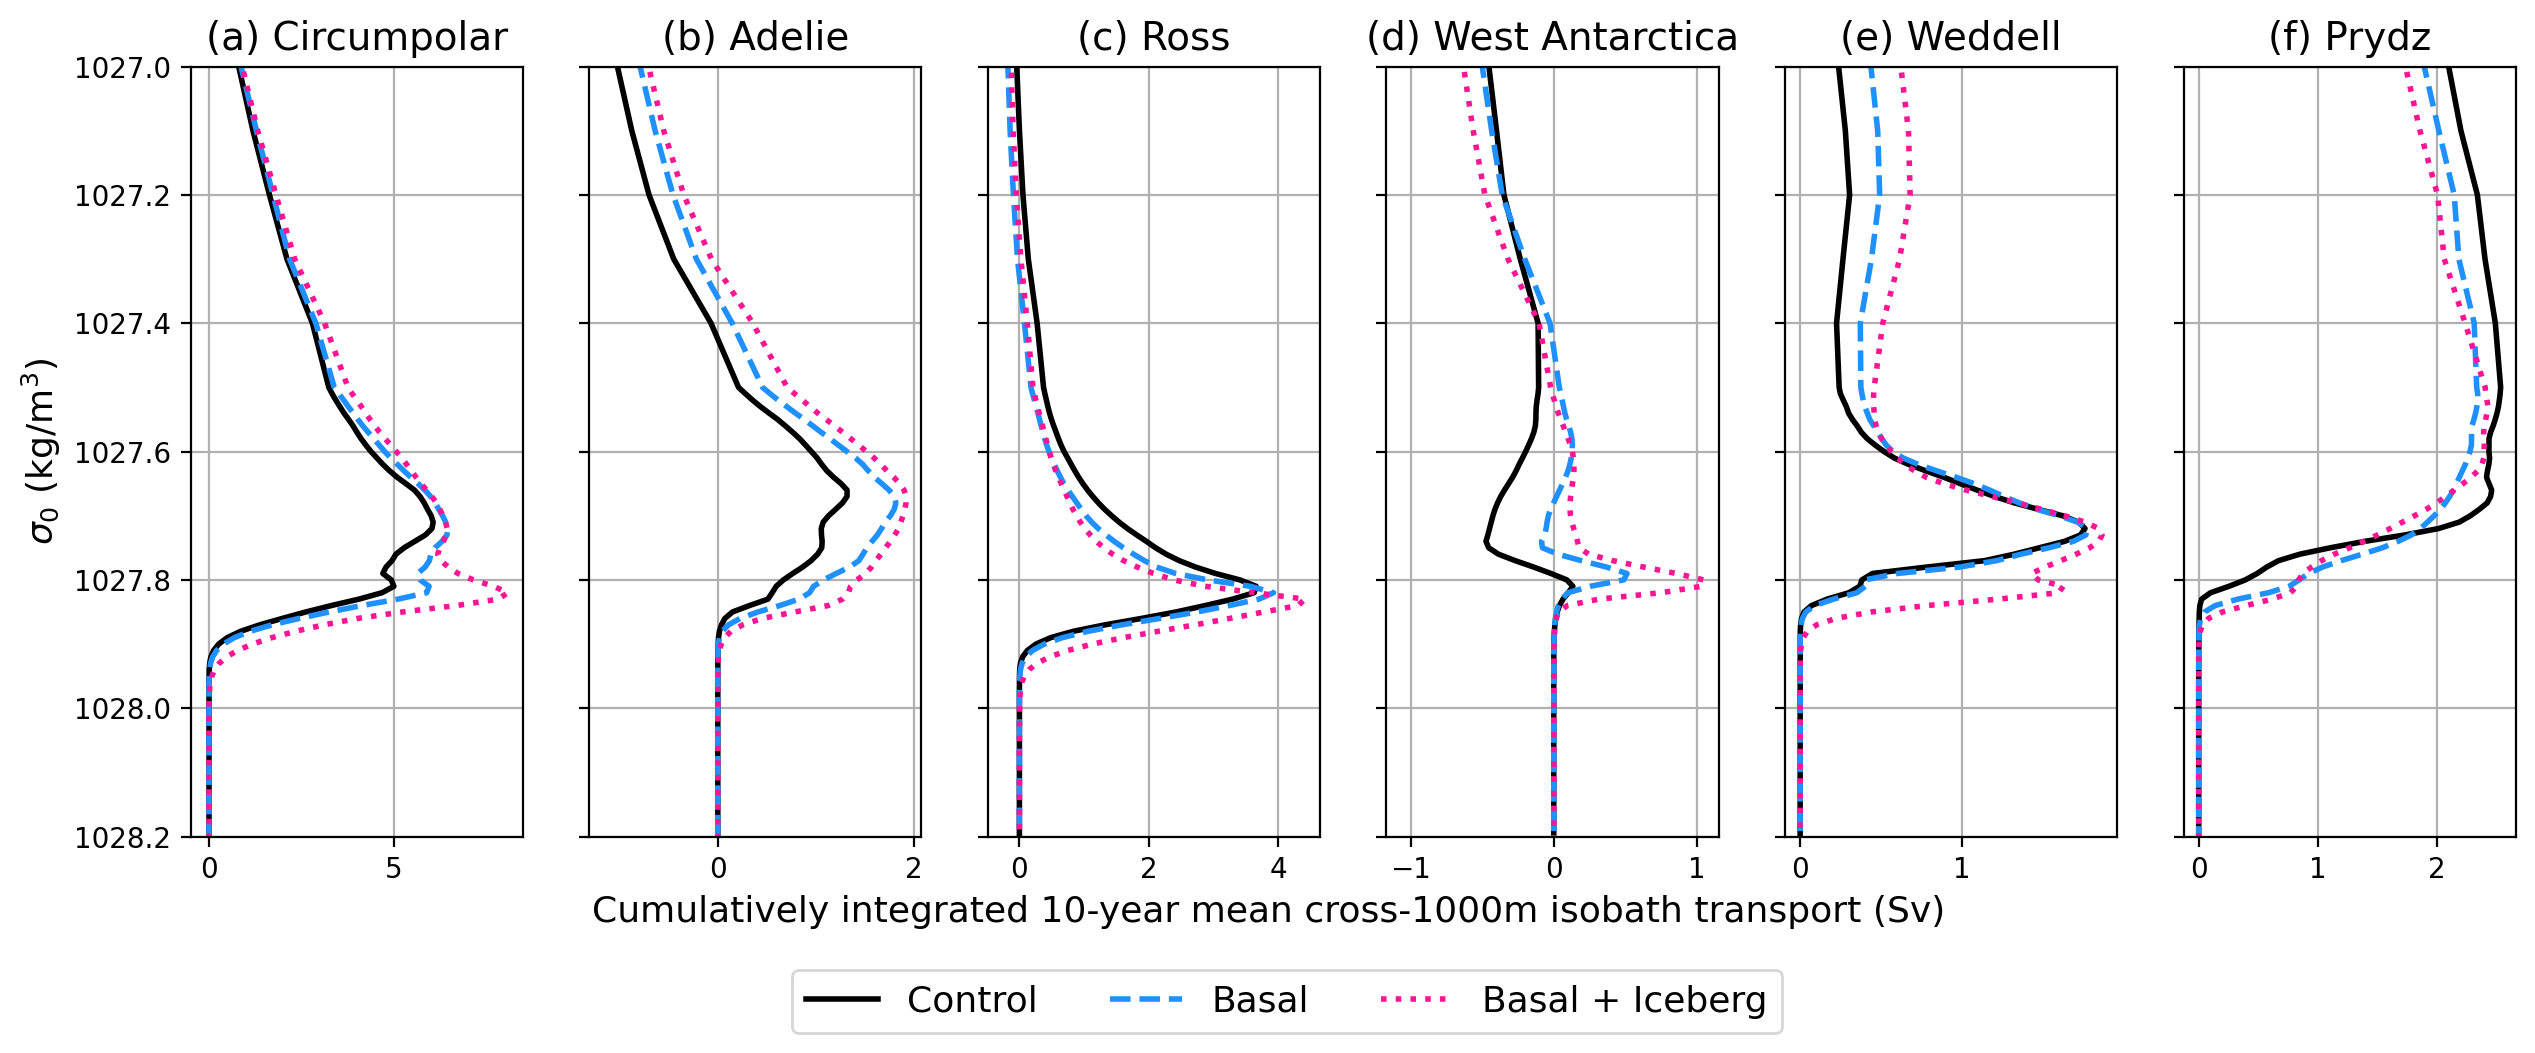

In [21]:
save_dir = '/g/data/x77/cy8964/basal_mom5-collaborative-project/notebooks/cross_contour/'
fig,axes = plt.subplots(nrows = 1, ncols = 6, figsize = (15,5), dpi = 200, sharey = True)
# plot individual years 
for n in np.arange(6):
    ax = [axes[0],axes[1],axes[2],axes[3],axes[4],axes[5]][n]
    sector = [slice(0,6002),Adelie, Ross, WA, Weddell, Prydz][n]
    sector_name = ['(a) Circumpolar','(b) Adelie', '(c) Ross', '(d) West Antarctica', '(e) Weddell', '(f) Prydz'][n]
    for i in np.arange(3):
        label = ['control','basal','icb'][i]
        Nice_label = ['Control', 'Basal', 'Basal + Iceberg'][i]
        array = xr.open_dataset(save_dir+label+'_vol_trans_across_contour_binned_10yr.nc').vol_trans_across_contour_binned_10yr
        color = ['k','dodgerblue','deeppink'][i]
        linestyle = ['-','--','dotted'][i]
        #yrly_arr = yrly(array)
        #yrly_arr.load()
        #for j in np.arange(10):
        #    b = (yrly_arr/1e6).isel(year = j).sel(contour_index = sector).sum('contour_index')
        #    (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(ax = ax, y = 'isopycnal_bins', color = color, alpha = 0.7-j*0.05, linewidth = 0.5)
        # plot mean 
        b = (array/1e6).sel(contour_index = sector).sum('contour_index')
        (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(ax = ax, y = 'isopycnal_bins', label = Nice_label,color = color, linestyle = linestyle,linewidth = 2)
    #plot control in black
    # a = (av_10yr(control_vol_trans)/1e6).sel(contour_index = sector).sum('contour_index')
    # (a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).plot(ax = ax, y = 'isopycnal_bins', label = 'control, 10 years',color = 'k', linestyle = '-',linewidth = 2)
    
    ax.set_ylim(1028.2,1027)
    ax.set_xlabel('                    Cumulatively integrated 10-year mean cross-1000m isobath transport (Sv)', fontsize = 13)
    ax.set_ylabel('$\sigma_0$ (kg/m$^3$)', fontsize = 13)
    ax.set_title(sector_name, fontsize = 14)
    ax.grid()
    if n ==3:
        ax.legend(bbox_to_anchor = (-0.3,-0.15), loc = 'upper center', ncol = 3, fontsize = 13)
#plt.savefig('offshore_transport_sum.png',dpi = 300)
#axes[2,1].axis('off')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[3].set_ylabel('')
axes[4].set_ylabel('')
axes[5].set_ylabel('')
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[3].set_xlabel('')
axes[4].set_xlabel('')
axes[5].set_xlabel('')


fig.subplots_adjust(hspace = 0.3)
plt.show()

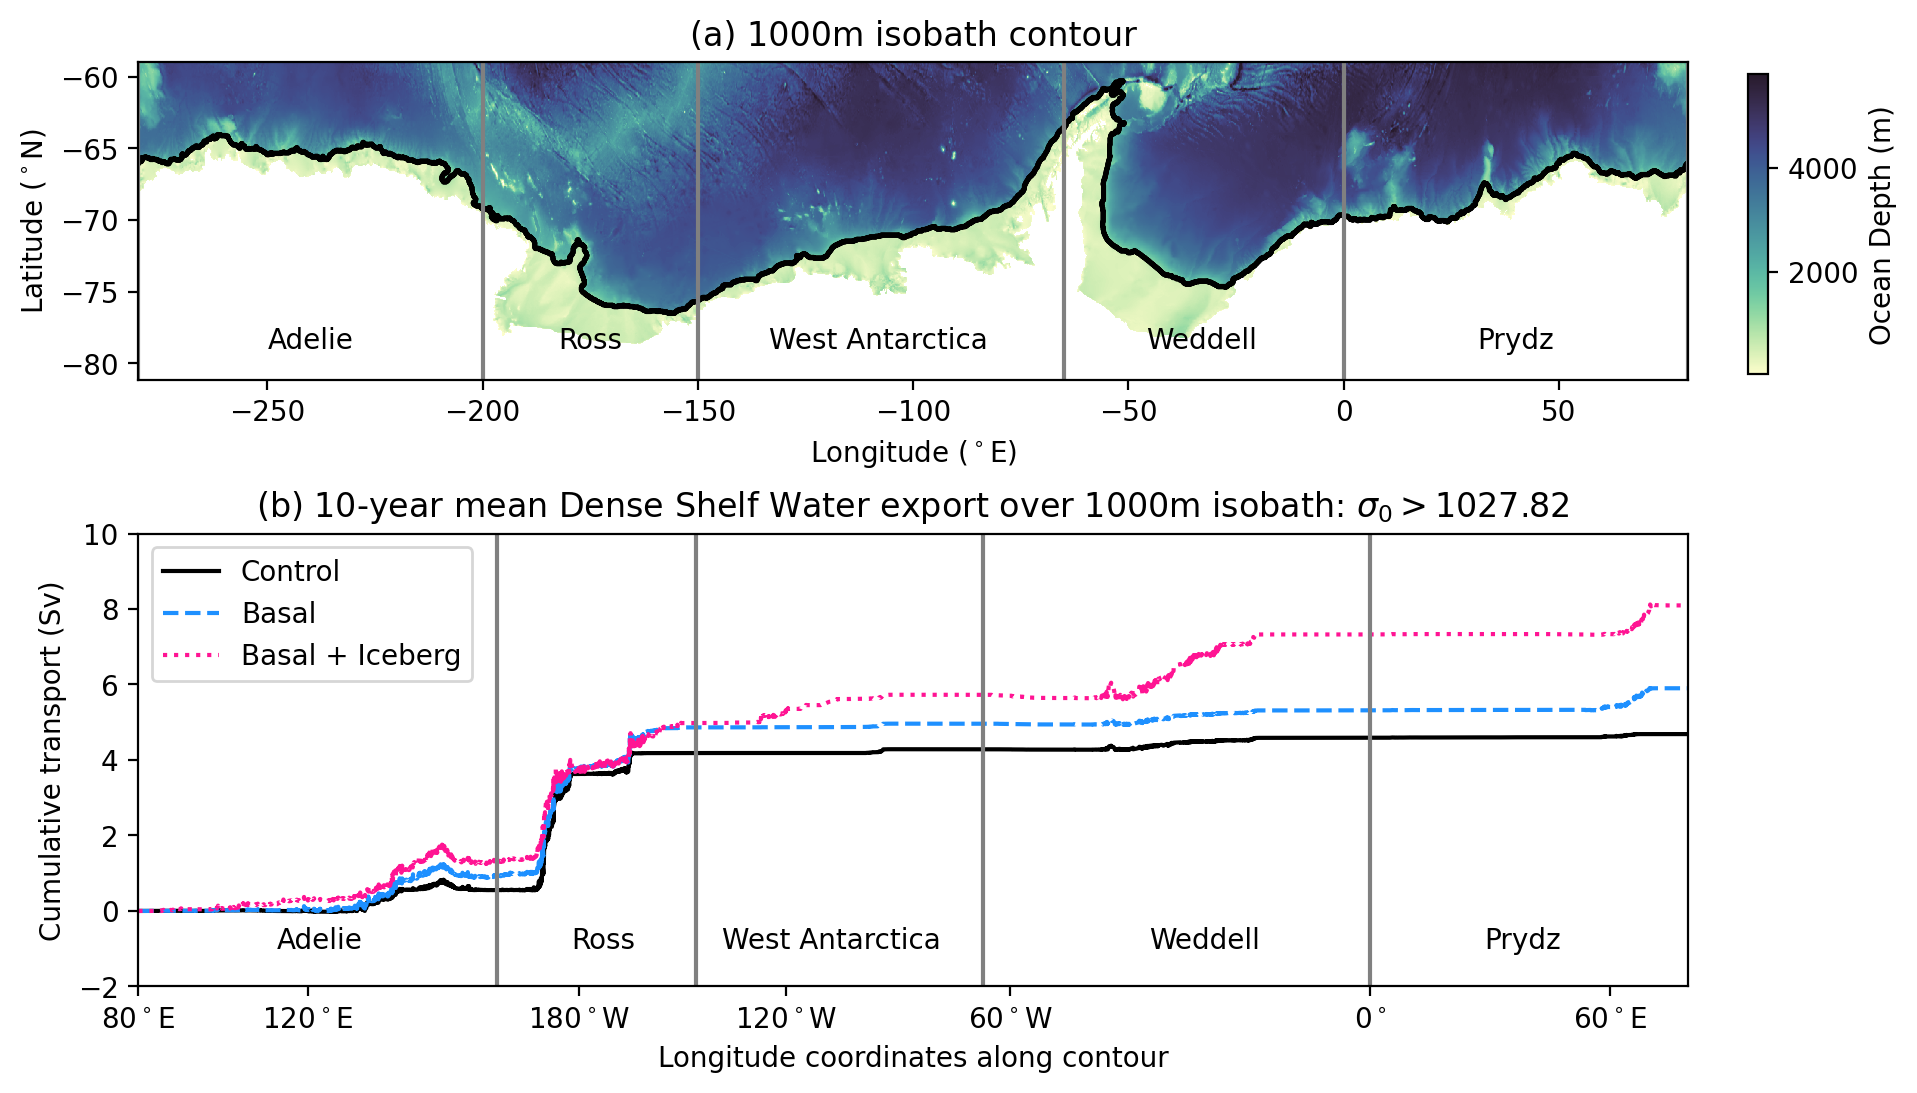

In [68]:
fig, axes = plt.subplots(nrows = 2, figsize = (10,6),dpi = 200, gridspec_kw={'height_ratios': [1.4, 2]})

ht = cc.querying.getvar(control, 'ht',master_session, n=1, ncfile = 'ocean_grid.nc')
ht = ht.sel(yt_ocean=lat_range)
yt_ocean = cc.querying.getvar(control, 'yt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
xt_ocean = cc.querying.getvar(control, 'xt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)


h_plot = ht.plot(ax = axes[0], cmap = cm.cm.deep, add_colorbar = False)
cax = plt.axes([0.93,0.62,0.01,0.25])
plt.colorbar(h_plot, cax = cax, label = 'Ocean Depth (m)')
axes[0].contour(xt_ocean.values, yt_ocean.values,np.abs(mask_x_transport.values)+np.abs(mask_y_transport.values),colors = 'k')

axes[0].vlines([-280,-200,-150,-65,0,80],-82,-58,  color = 'grey')
axes[0].text(-240, -79, 'Adelie', horizontalalignment='center')
axes[0].text(-175, -79, 'Ross', horizontalalignment='center')
axes[0].text(-108, -79, 'West Antarctica', horizontalalignment='center')
axes[0].text(-33, -79, 'Weddell', horizontalalignment='center')
axes[0].text(40, -79, 'Prydz', horizontalalignment='center')

axes[0].set_title('(a) 1000m isobath contour')
axes[0].set_ylabel('Latitude ($^\circ$N)')
axes[0].set_xlabel('Longitude ($^\circ$E)')


density_slice = slice(1027.82,1030)
for i in np.arange(3):
    label = ['control','basal','icb'][i]
    Nice_label = ['Control', 'Basal', 'Basal + Iceberg'][i]
    array = xr.open_dataset(save_dir+label+'_vol_trans_across_contour_binned_10yr.nc').vol_trans_across_contour_binned_10yr
    color = ['k','dodgerblue','deeppink'][i]
    linestyle = ['-','--','dotted'][i]
    axes[1].plot(distance_along_contour,(10**(-6)*array.sel(isopycnal_bins = density_slice)).sum('isopycnal_bins').cumsum('contour_index'),label = Nice_label, color = color, linestyle = linestyle)

axes[1].set_ylabel('Cumulative transport (Sv)')
axes[1].set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes[1].set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes[1].set_xlim(0,distance_along_contour[-1]);
axes[1].set_xlabel('Longitude coordinates along contour')

inds= [1270, 2149, 3338, 4798]
axes[1].vlines(distance_along_contour[inds],-2,10,  color = 'grey')
axes[1].text(distance_along_contour[635], -1, 'Adelie', horizontalalignment='center')
axes[1].text(distance_along_contour[1709], -1, 'Ross', horizontalalignment='center')
axes[1].text(distance_along_contour[2743], -1, 'West Antarctica', horizontalalignment='center')
axes[1].text(distance_along_contour[4068], -1, 'Weddell', horizontalalignment='center')
axes[1].text(distance_along_contour[5399], -1, 'Prydz', horizontalalignment='center')
axes[1].set_ylim(-2,10)
axes[1].legend(loc = 'upper left')
axes[1].set_title('(b) 10-year mean Dense Shelf Water export over 1000m isobath: $\sigma_0 > 1027.82$')

fig.subplots_adjust(hspace = 0.4)

# Combine:

In [25]:
from matplotlib import gridspec


In [ ]:
gs = gridspec.GridSpec(3,6, height_ratios = [0.6,1,0.8]) 
fig = plt.figure(figsize = (10,10),dpi = 200)
ax0, ax1, ax2, ax3, ax4, ax5,ax6,ax7 = plt.subplot(gs[0,:]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1]), plt.subplot(gs[1,2]),plt.subplot(gs[1,3]),plt.subplot(gs[1,4]),plt.subplot(gs[1,5]),plt.subplot(gs[2,:])

ht = cc.querying.getvar(control, 'ht',master_session, n=1, ncfile = 'ocean_grid.nc')
ht = ht.sel(yt_ocean=lat_range)
yt_ocean = cc.querying.getvar(control, 'yt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
xt_ocean = cc.querying.getvar(control, 'xt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)


h_plot = ht.plot(ax = ax0, cmap = cm.cm.deep, add_colorbar = False)
cax = plt.axes([0.93,0.62,0.01,0.25])
plt.colorbar(h_plot, cax = cax, label = 'Ocean Depth (m)')
ax0.contour(xt_ocean.values, yt_ocean.values,np.abs(mask_x_transport.values)+np.abs(mask_y_transport.values),colors = 'k')

ax0.vlines([-280,-200,-150,-65,0,80],-82,-58,  color = 'grey')
ax0.text(-240, -79, 'Adelie', horizontalalignment='center')
ax0.text(-175, -79, 'Ross', horizontalalignment='center')
ax0.text(-108, -79, 'West Antarctica', horizontalalignment='center')
ax0.text(-33, -79, 'Weddell', horizontalalignment='center')
ax0.text(40, -79, 'Prydz', horizontalalignment='center')

ax0.set_title('(a) 1000m isobath contour')
ax0.set_ylabel('Latitude ($^\circ$N)')
ax0.set_xlabel('Longitude ($^\circ$E)')

save_dir = '/g/data/x77/cy8964/basal_mom5-collaborative-project/notebooks/cross_contour/'
# plot individual years 
for n in np.arange(6):
    print(n)
    ax = [ax1,ax2,ax3,ax4,ax5,ax6][n]
    sector = [slice(0,6002),Adelie, Ross, WA, Weddell, Prydz][n]
    sector_name = ['(b) Circumpolar','(c) Adelie', '(d) Ross', '(e) West Antarctica', '(f) Weddell', '(g) Prydz'][n]
    for i in np.arange(3):
        label = ['control','basal','icb'][i]
        Nice_label = ['Control', 'Basal', 'Basal + Iceberg'][i]
        array = xr.open_dataset(save_dir+label+'_vol_trans_across_contour_binned_10yr.nc').vol_trans_across_contour_binned_10yr
        color = ['k','dodgerblue','deeppink'][i]
        linestyle = ['-','--','dotted'][i]
        #yrly_arr = yrly(array)
        #yrly_arr.load()
        #for j in np.arange(10):
        #    b = (yrly_arr/1e6).isel(year = j).sel(contour_index = sector).sum('contour_index')
        #    (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(ax = ax, y = 'isopycnal_bins', color = color, alpha = 0.7-j*0.05, linewidth = 0.5)
        # plot mean 
        b = (array/1e6).sel(contour_index = sector).sum('contour_index')
        (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(ax = ax, y = 'isopycnal_bins', label = Nice_label,color = color, linestyle = linestyle,linewidth = 2)
    #plot control in black
    # a = (av_10yr(control_vol_trans)/1e6).sel(contour_index = sector).sum('contour_index')
    # (a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).plot(ax = ax, y = 'isopycnal_bins', label = 'control, 10 years',color = 'k', linestyle = '-',linewidth = 2)
    
    ax.set_ylim(1028.2,1027)
    ax.set_title(sector_name, fontsize = 14)
    ax.grid()
    if n == 0:
        ax.set_ylabel('$\sigma_0$ (kg/m$^3$)', fontsize = 13)
    if n ==2:
        ax.set_xlabel('                    Cumulatively integrated 10-year mean cross-1000m isobath transport (Sv)', fontsize = 13)  
    if n ==3:
        ax.legend(bbox_to_anchor = (-0.3,-0.15), loc = 'upper center', ncol = 3, fontsize = 13)


density_slice = slice(1027.82,1030)
for i in np.arange(3):
    label = ['control','basal','icb'][i]
    Nice_label = ['Control', 'Basal', 'Basal + Iceberg'][i]
    array = xr.open_dataset(save_dir+label+'_vol_trans_across_contour_binned_10yr.nc').vol_trans_across_contour_binned_10yr
    color = ['k','dodgerblue','deeppink'][i]
    linestyle = ['-','--','dotted'][i]
    ax7.plot(distance_along_contour,(10**(-6)*array.sel(isopycnal_bins = density_slice)).sum('isopycnal_bins').cumsum('contour_index'),label = Nice_label, color = color, linestyle = linestyle)
    ax7.text(distance_along_contour[:-1]+0.2,(10**(-6)*array.sel(isopycnal_bins = density_slice)).sum('isopycnal_bins').cumsum('contour_index')[:-1],
             str((10**(-6)*array.sel(isopycnal_bins = density_slice)).sum('isopycnal_bins').cumsum('contour_index')[:-1].values) + ' Sv', color = color)
ax7.set_ylabel('Cumulative transport (Sv)')
ax7.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
ax7.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
ax7.set_xlim(0,distance_along_contour[-1]);
ax7.set_xlabel('Longitude coordinates along contour')

inds= [1270, 2149, 3338, 4798]
ax7.vlines(distance_along_contour[inds],-2,10,  color = 'grey')
ax7.text(distance_along_contour[635], -1, 'Adelie', horizontalalignment='center')
ax7.text(distance_along_contour[1709], -1, 'Ross', horizontalalignment='center')
ax7.text(distance_along_contour[2743], -1, 'West Antarctica', horizontalalignment='center')
ax7.text(distance_along_contour[4068], -1, 'Weddell', horizontalalignment='center')
ax7.text(distance_along_contour[5399], -1, 'Prydz', horizontalalignment='center')
ax7.set_ylim(-2,10)
ax7.legend(loc = 'upper left')
ax7.set_title('(h) 10-year mean Dense Shelf Water export over 1000m isobath: $\sigma_0 > 1027.82$')

fig.subplots_adjust(hspace = 0.4)